# Implementacja bibliotek


In [1]:
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors 

# Wizualizacja danych
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from textblob import TextBlob
from plotly import tools

#Ignorowanie ostrzeżeń
import warnings
warnings.filterwarnings('ignore')

#Import danych z pliku
train = pd.read_csv('Musical_instruments_reviews.csv')

### Wyeksponowanie struktury tabelii

In [2]:
print ("Struktura tabeli (wiersze, kolumny):"+ str(train.shape))
print (train.info())

Struktura tabeli (wiersze, kolumny):(10261, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB
None


### Podgląd danych 


In [3]:
train.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"


### Modyfikacja zestawu danych
Zamienienie pustych wartości na 'missing'

Stworzenie kopii kolumn 'reviewText' 'summary' 

In [4]:
train['reviewText']=train['reviewText'].fillna('Missing')
train['reviews']=train['reviewText']+train['summary']
train_copy=train.drop(['reviewText', 'summary'], axis=1)
train_copy.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014","Not much to write about here, but it does exac..."
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",The product does exactly as it should and is q...
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",The primary job of this device is to block the...
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",Nice windscreen protects my MXL mic and preven...
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",This pop filter is great. It looks and perform...


In [5]:
train_copy['overall'].value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

<AxesSubplot:>

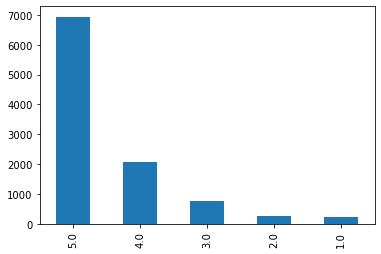

In [6]:
train['overall'].value_counts().plot.bar()

In [7]:
def f(row):
        
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
        val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [8]:
train['sentiment'] = train.apply(f, axis=1)
train.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviews,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014","Not much to write about here, but it does exac...",Positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013",The product does exactly as it should and is q...,Positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013",The primary job of this device is to block the...,Positive
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",Nice windscreen protects my MXL mic and preven...,Positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014",This pop filter is great. It looks and perform...,Positive


In [9]:
train['sentiment'].value_counts()

Positive    9022
Neutral      772
Negative     467
Name: sentiment, dtype: int64

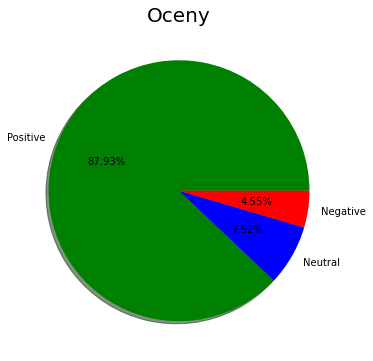

In [10]:
plt.figure(figsize=(10,6))
colors=['green','blue','red']
 
plt.pie(train['sentiment'].value_counts(normalize=True),colors=colors,labels=['Positive','Neutral','Negative'],autopct='%1.2f%%',shadow=True)
plt.title('Oceny',fontsize=20)

plt.show()

In [11]:
new = train["reviewTime"].str.split(",", n = 1, expand = True) 
train["date"]= new[0] 
train["year"]= new[1] 
train=train.drop(['reviewTime'], axis=1)
train.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviews,sentiment,date,year
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"Not much to write about here, but it does exac...",Positive,02 28,2014
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,The product does exactly as it should and is q...,Positive,03 16,2013
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,The primary job of this device is to block the...,Positive,08 28,2013
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,Nice windscreen protects my MXL mic and preven...,Positive,02 14,2014
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,This pop filter is great. It looks and perform...,Positive,02 21,2014


In [12]:
new1 = train["date"].str.split(" ", n = 1, expand = True) 
train["month"]= new1[0] 
train["day"]= new1[1] 
train=train.drop(['date'], axis=1)
train.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviews,sentiment,year,month,day
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"Not much to write about here, but it does exac...",Positive,2014,02,28
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,The product does exactly as it should and is q...,Positive,2013,03,16
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,The primary job of this device is to block the...,Positive,2013,08,28
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,Nice windscreen protects my MXL mic and preven...,Positive,2014,02,14
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,This pop filter is great. It looks and perform...,Positive,2014,02,21


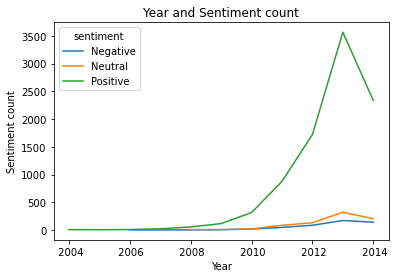

In [13]:
train.groupby(['year','sentiment'])['sentiment'].count().unstack().plot(legend=True)
plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

#### Załadawanie treści oceny oraz liczby jej słów


In [14]:
train['word_count'] = train['reviews'].apply(lambda x: len(str(x).split(" ")))
train[['reviews','word_count']].head()

,reviews,word_count
0,"Not much to write about here, but it does exac...",51
1,The product does exactly as it should and is q...,104
2,The primary job of this device is to block the...,81
3,Nice windscreen protects my MXL mic and preven...,39
4,This pop filter is great. It looks and perform...,35


# WSTĘPNA ANALIZA DANYCH

In [15]:
nltk.download('stopwords')
stop = stopwords.words('english')

train['stopwords'] = train['reviewText'].apply(lambda x: len([x for x in str(x).split() if x in stop]))
train[['reviewText','stopwords']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tomek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,reviewText,stopwords
0,"Not much to write about here, but it does exac...",24
1,The product does exactly as it should and is q...,47
2,The primary job of this device is to block the...,29
3,Nice windscreen protects my MXL mic and preven...,14
4,This pop filter is great. It looks and perform...,10


### Liczba znaków interpunkcyjnych w recenzji


In [16]:
train['commas'] = train['reviewText'].apply(lambda x: len([x for x in str(x).split() if x.endswith(',') or x.endswith('.')]))
train[['reviewText','commas']].head()

,reviewText,commas
0,"Not much to write about here, but it does exac...",6
1,The product does exactly as it should and is q...,7
2,The primary job of this device is to block the...,5
3,Nice windscreen protects my MXL mic and preven...,2
4,This pop filter is great. It looks and perform...,3


#### Największa,najmniejsza oraz średnia liczba znaków interpunkcyjnych w recenzji


In [17]:
x=[]
x.append(["max:",train[['commas']].max()])
x.append(["min:",train[['commas']].min()])
x.append(["mean:",train[['commas']].mean()])

x

[['max:',
  commas    175
  dtype: int64],
 ['min:',
  commas    0
  dtype: int64],
 ['mean:',
  commas    8.144333
  dtype: float64]]

In [18]:
#Liczba znaków numerycznytch
train['numerics'] = train['reviewText'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))
train[['reviewText','numerics']].head()

,reviewText,numerics
0,"Not much to write about here, but it does exac...",0
1,The product does exactly as it should and is q...,0
2,The primary job of this device is to block the...,0
3,Nice windscreen protects my MXL mic and preven...,0
4,This pop filter is great. It looks and perform...,0


#### Największa,najmniejsza oraz średnia liczba znaków numerycznytch w recenzji


In [19]:
y=[]
y.append(["max:",train[['numerics']].max()])
y.append(["min:",train[['numerics']].min()])
y.append(["mean:",train[['numerics']].mean()])

y

[['max:',
  numerics    27
  dtype: int64],
 ['min:',
  numerics    0
  dtype: int64],
 ['mean:',
  numerics    0.430952
  dtype: float64]]

# WSTĘPNA NORMALIZACJA

#### Następnie pozbycie się znaków interpunkcyjnych


In [20]:
train['reviewText'] = train['reviewText'].str.replace('[^\w\s]','')
train['reviewText'].head()

0    Not much to write about here but it does exact...
1    The product does exactly as it should and is q...
2    The primary job of this device is to block the...
3    Nice windscreen protects my MXL mic and preven...
4    This pop filter is great It looks and performs...
Name: reviewText, dtype: object

#### Zamiana wielkości wszystkich liter na małe


In [21]:
train['reviewText'] = train['reviewText'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
train['reviewText'].head()

0    not much to write about here but it does exact...
1    the product does exactly as it should and is q...
2    the primary job of this device is to block the...
3    nice windscreen protects my mxl mic and preven...
4    this pop filter is great it looks and performs...
Name: reviewText, dtype: object

#### Pozbycie się słów z listy stop-words


In [22]:
train['reviewText'] = train['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train['reviewText'].head()

0    much write exactly supposed filters pop sounds...
1    product exactly quite affordablei realized dou...
2    primary job device block breath would otherwis...
3    nice windscreen protects mxl mic prevents pops...
4    pop filter great looks performs like studio fi...
Name: reviewText, dtype: object

# ANALIZA DANYCH

#### Lista 20 najczęściej występujących słów


In [23]:
freq = pd.Series(' '.join(train['reviewText']).split()).value_counts()[:20]
freq

guitar     5386
one        4354
great      3979
like       3883
use        3708
good       3679
sound      3487
strings    3322
well       3018
get        2644
pedal      2500
would      2360
really     2227
price      2131
dont       2062
little     2048
much       1965
amp        1963
works      1833
ive        1828
dtype: int64

<AxesSubplot:>

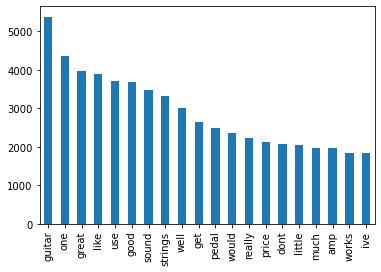

In [24]:
freq.plot.bar()

#### Lista 20 najrzadziej występujących słów


In [25]:
freq = pd.Series(' '.join(train['reviewText']).split()).value_counts()[-20:]
freq

bottomend         1
aussie            1
artso             1
onedifferent      1
scrap             1
bids              1
font              1
backalesis        1
pulsed            1
qualityother      1
overhumidifing    1
outthere          1
bbs               1
thingthis         1
verdictone        1
thoughthey        1
exspecially       1
wowit             1
panhandle         1
ampetc            1
dtype: int64

#### Recenzje najdłuższa, najkrótsza, średnia długość


In [26]:
train['word_count'] = train['reviewText'].apply(lambda x: len(str(x).split(" ")))
train[['word_count']].max()

word_count    1113
dtype: int64

In [27]:
train[['word_count']].min()

word_count    1
dtype: int64

In [28]:
train[['word_count']].mean()

word_count    46.215281
dtype: float64

# NORMALIZACJA

Poprawa pisowni przy użyciu TextBlob


In [29]:
train['reviewText'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    much write exactly supposed filters pop sounds...
1    product exactly quite affordablei realized dou...
2    primary job device block breath would otherwis...
3    nice windscreen protects mal mid prevents pips...
4    pop filter great looks perform like studio fil...
Name: reviewText, dtype: object

#### Tokenizacja


In [30]:
nltk.download('punkt')
TextBlob(train['reviewText'][1]).words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tomek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


WordList(['product', 'exactly', 'quite', 'affordablei', 'realized', 'double', 'screened', 'arrived', 'even', 'better', 'expectedas', 'added', 'bonus', 'one', 'screens', 'carries', 'small', 'hint', 'smell', 'old', 'grape', 'candy', 'used', 'buy', 'reminiscents', 'sake', 'can', 'not', 'stop', 'putting', 'pop', 'filter', 'next', 'nose', 'smelling', 'recording', 'dif', 'needed', 'pop', 'filter', 'work', 'well', 'expensive', 'ones', 'may', 'even', 'come', 'pleasing', 'aroma', 'like', 'mine', 'didbuy', 'product'])

#### Lematyzacja


In [31]:
nltk.download('wordnet')
train['reviewText'] = train['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
train['reviewText'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tomek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    much write exactly supposed filter pop sound r...
1    product exactly quite affordablei realized dou...
2    primary job device block breath would otherwis...
3    nice windscreen protects mxl mic prevents pop ...
4    pop filter great look performs like studio fil...
Name: reviewText, dtype: object

##### Bigram


In [32]:
TextBlob(train['reviewText'][0]).ngrams(2)

[WordList(['much', 'write']),
 WordList(['write', 'exactly']),
 WordList(['exactly', 'supposed']),
 WordList(['supposed', 'filter']),
 WordList(['filter', 'pop']),
 WordList(['pop', 'sound']),
 WordList(['sound', 'recording']),
 WordList(['recording', 'much']),
 WordList(['much', 'crisp']),
 WordList(['crisp', 'one']),
 WordList(['one', 'lowest']),
 WordList(['lowest', 'price']),
 WordList(['price', 'pop']),
 WordList(['pop', 'filter']),
 WordList(['filter', 'amazon']),
 WordList(['amazon', 'might']),
 WordList(['might', 'well']),
 WordList(['well', 'buy']),
 WordList(['buy', 'honestly']),
 WordList(['honestly', 'work']),
 WordList(['work', 'despite']),
 WordList(['despite', 'pricing'])]

#### Trigram


In [33]:
TextBlob(train['reviewText'][0]).ngrams(3)

[WordList(['much', 'write', 'exactly']),
 WordList(['write', 'exactly', 'supposed']),
 WordList(['exactly', 'supposed', 'filter']),
 WordList(['supposed', 'filter', 'pop']),
 WordList(['filter', 'pop', 'sound']),
 WordList(['pop', 'sound', 'recording']),
 WordList(['sound', 'recording', 'much']),
 WordList(['recording', 'much', 'crisp']),
 WordList(['much', 'crisp', 'one']),
 WordList(['crisp', 'one', 'lowest']),
 WordList(['one', 'lowest', 'price']),
 WordList(['lowest', 'price', 'pop']),
 WordList(['price', 'pop', 'filter']),
 WordList(['pop', 'filter', 'amazon']),
 WordList(['filter', 'amazon', 'might']),
 WordList(['amazon', 'might', 'well']),
 WordList(['might', 'well', 'buy']),
 WordList(['well', 'buy', 'honestly']),
 WordList(['buy', 'honestly', 'work']),
 WordList(['honestly', 'work', 'despite']),
 WordList(['work', 'despite', 'pricing'])]

#### Częstotliwość występowania fraz oraz odwrotna częstotliwość występowania fraz


In [34]:
tf1 = (train['reviewText'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']

In [35]:
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(train.shape[0]/(len(train[train['reviewText'].str.contains(word)])))
tf1

,words,tf,idf
0,filter,2,4.407792
1,pop,2,3.706676
2,even,2,2.126226
3,one,2,0.727953
4,product,2,2.195569
5,candy,1,6.671156
6,needed,1,2.970804
7,smell,1,5.324083
8,small,1,2.403074
9,aroma,1,9.236106


# Wektoryzacja


In [36]:
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [37]:
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [38]:
model['go']

array([-0.078894,  0.4616  ,  0.57779 , -0.71637 , -0.13121 ,  0.4186  ,
       -0.29156 ,  0.52006 ,  0.089986, -0.35062 ,  0.51755 ,  0.51998 ,
        0.15218 ,  0.41485 , -0.12377 , -0.37222 ,  0.0273  ,  0.75673 ,
       -0.8739  ,  0.58935 ,  0.46662 ,  0.62918 ,  0.092603, -0.012868,
       -0.015169,  0.25567 , -0.43025 , -0.77668 ,  0.71449 , -0.3834  ,
       -0.69638 ,  0.23522 ,  0.11396 ,  0.02778 ,  0.071357,  0.87409 ,
       -0.1281  ,  0.063576,  0.067867, -0.50181 , -0.28523 , -0.072536,
       -0.50738 , -0.6914  , -0.53579 , -0.11361 , -0.38234 , -0.12414 ,
        0.011214, -1.1622  ,  0.037057, -0.18495 ,  0.01416 ,  0.87193 ,
       -0.097309, -2.3565  , -0.14554 ,  0.28275 ,  2.0053  ,  0.23439 ,
       -0.38298 ,  0.69539 , -0.44916 , -0.094157,  0.90527 ,  0.65764 ,
        0.27628 ,  0.30688 , -0.57781 , -0.22987 , -0.083043, -0.57236 ,
       -0.299   , -0.81112 ,  0.039752, -0.05681 , -0.48879 , -0.18091 ,
       -0.28152 , -0.20559 ,  0.4932  , -0.033999, 

In [39]:
model['away']

array([-0.10379 , -0.014792,  0.59933 , -0.51316 , -0.036463,  0.6588  ,
       -0.57906 ,  0.17819 ,  0.23663 , -0.21384 ,  0.55339 ,  0.53597 ,
        0.041444,  0.16095 ,  0.017093, -0.37242 ,  0.017974,  0.39268 ,
       -0.23265 ,  0.1818  ,  0.66405 ,  0.98163 ,  0.42339 ,  0.030581,
        0.35015 ,  0.25519 , -0.71182 , -0.42184 ,  0.13068 , -0.47452 ,
       -0.08175 ,  0.1574  , -0.13262 ,  0.22679 , -0.16885 , -0.11122 ,
       -0.32272 , -0.020978, -0.43345 ,  0.172   , -0.67366 , -0.79052 ,
        0.10556 , -0.4219  , -0.12385 , -0.063486, -0.17843 ,  0.56359 ,
        0.16986 , -0.17804 ,  0.13956 , -0.20169 ,  0.078985,  1.4497  ,
        0.23556 , -2.6014  , -0.5286  , -0.11636 ,  1.7184  ,  0.33254 ,
        0.12136 ,  1.1602  , -0.2914  ,  0.47125 ,  0.41869 ,  0.35271 ,
        0.47869 , -0.042281, -0.18294 ,  0.1796  , -0.24431 , -0.34042 ,
        0.20337 , -0.93676 ,  0.013077,  0.080339, -0.36604 , -0.44005 ,
       -0.35393 ,  0.15907 ,  0.55807 ,  0.1492  , 

In [40]:
(model['go'] + model['away'])/2

array([-0.091342  ,  0.223404  ,  0.58856   , -0.614765  , -0.0838365 ,
        0.5387    , -0.43531   ,  0.349125  ,  0.163308  , -0.28223   ,
        0.53547   ,  0.52797496,  0.096812  ,  0.2879    , -0.0533385 ,
       -0.37232   ,  0.022637  ,  0.574705  , -0.553275  ,  0.385575  ,
        0.565335  ,  0.805405  ,  0.2579965 ,  0.0088565 ,  0.1674905 ,
        0.25543   , -0.571035  , -0.59926   ,  0.422585  , -0.42896   ,
       -0.389065  ,  0.19631   , -0.00933   ,  0.127285  , -0.0487465 ,
        0.381435  , -0.22540998,  0.021299  , -0.1827915 , -0.16490501,
       -0.47944498, -0.431528  , -0.20091   , -0.55665   , -0.32982   ,
       -0.088548  , -0.28038502,  0.219725  ,  0.090537  , -0.67012   ,
        0.0883085 , -0.19332   ,  0.0465725 ,  1.160815  ,  0.0691255 ,
       -2.47895   , -0.33707   ,  0.083195  ,  1.86185   ,  0.283465  ,
       -0.13081   ,  0.927795  , -0.37028   ,  0.1885465 ,  0.66198   ,
        0.505175  ,  0.37748498,  0.1322995 , -0.380375  , -0.02

### Analiza tekstu


In [41]:
train['sentimet'] = train['reviewText'].apply(lambda x: TextBlob(x).sentiment[0])
train[['reviewText', 'sentimet', 'overall', 'summary']].head(15)

,reviewText,sentimet,overall,summary
0,much write exactly supposed filter pop sound r...,0.340000,5.0,good
1,product exactly quite affordablei realized dou...,0.014286,5.0,Jake
2,primary job device block breath would otherwis...,0.167500,5.0,It Does The Job Well
3,nice windscreen protects mxl mic prevents pop ...,0.333333,5.0,GOOD WINDSCREEN FOR THE MONEY
4,pop filter great look performs like studio fil...,0.800000,5.0,No more pops when I record my vocals.
5,good bought another one love heavy cord gold c...,0.305556,5.0,The Best Cable
6,used monster cable year good reason lifetime w...,0.333333,5.0,Monster Standard 100 - 21' Instrument Cable
7,use cable run output pedal chain input fender ...,0.062096,3.0,Didn't fit my 1996 Fender Strat...
8,perfect epiphone sheraton ii monster cable wel...,0.500000,5.0,Great cable
9,monster make best cable lifetime warranty does...,0.330000,5.0,Best Instrument Cables On The Market
